<a href="https://colab.research.google.com/github/lotterinng/Aster-Indices-For-Exploration_-KCB/blob/main/Aster_Indices_For_Exploration__KCB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --q earthengine-api
!pip install --q geemap

In [ ]:
import ee
ee.Authenticate()  # This will prompt you to authenticate
ee.Initialize(project='ee-ub-research')    # Initialize the Earth Engine API

In [ ]:
import geemap

In [ ]:
import geemap
# Define the asset ID of your polygon
polygon_asset_id = 'projects/absaprojectprototype/assets/KalahariCopperbelt'  # Replace with your asset ID

# Load the polygon asset
roi = ee.FeatureCollection(polygon_asset_id)

# Print the asset information
print('Polygon Asset Info:')
print(roi.getInfo())

Polygon Asset Info:
{'type': 'FeatureCollection', 'columns': {'AREA': 'Float', 'DEPTH_M_': 'Long', 'KALAHARI': 'String', 'PERIMETER': 'Float', 'SID': 'Long', 'ZERO_CT_': 'Long', 'ZERO_CT_ID': 'Long', 'system:index': 'String'}, 'version': 1744373314592058, 'id': 'projects/absaprojectprototype/assets/KalahariCopperbelt', 'properties': {'system:asset_size': 24111}, 'features': [{'type': 'Feature', 'geometry': {'type': 'Polygon', 'coordinates': [[[23.45859492326309, -20.611534656995083], [23.458978351777624, -20.620475204580284], [23.46460575755512, -20.633428866928355], [23.47341692627119, -20.636956032055323], [23.47699758525304, -20.635908133773643], [23.475436936844787, -20.626392408833418], [23.473751384821988, -20.62245505167484], [23.469256617133585, -20.611753150488354], [23.46580526486982, -20.607222707386647], [23.461038469741688, -20.60823495018823], [23.45859492326309, -20.611534656995083]]]}, 'id': '00000000000000000002', 'properties': {'AREA': 0, 'DEPTH_M_': 0, 'KALAHARI': 'S

In [ ]:
# 'roi' is ee.FeatureCollection
# union() merges all polygons into one geometry, but it returns a single Feature
roi_feature = roi.union(1)  # 1 is your maxError in meters

# Convert that Feature to a geometry:
roi_geometry = roi_feature.geometry() \
    .buffer(0, 10) \
    .simplify(10000)


# Iron Oxides

## indicate ferric iron

In [ ]:
datasetFI = ee.ImageCollection('ASTER/AST_L1T_003') \
            .filter(ee.Filter.date('2000-01-01', '2020-12-31')) \
            .filterBounds(roi_geometry) \
            .filter(ee.Filter.lt('CLOUDCOVER', 5));

mineralIndexFI = datasetFI.map(lambda img: img.expression(
    'B02 / B01',
    {
      'B02': img.select('B02'),
      'B01': img.select('B01')
    }
))

# Clip the dataset to the ROI
clipped_MineralIndexFI = mineralIndexFI.map(lambda img: img.clip(roi_geometry))
meanMineralIndexFI = clipped_MineralIndexFI.median()

# Define visualization parameters for the mineral index.
mineralIndexVis = {
    'min': 0.0,
    'max': 2.0,
    'palette': ['blue', 'white', 'red']
}

# Display the index on an interactive map
Map = geemap.Map()
Map.addLayer(meanMineralIndexFI, mineralIndexVis, 'Mineral Index (B05/B3N)')
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
!pip install --q matplotlib
!pip install --q rasterio
!pip install --q geopandas

# Import libraries and authenticate

import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import rasterio
from rasterio.plot import show
import numpy as np
from rasterio.features import geometry_mask  # Correct import


# 3. Convert the ee.Geometry to an ee.Feature
roi_feature_final = ee.Feature(roi_geometry)

# 4. Wrap that feature in a FeatureCollection
roi_fc_final = ee.FeatureCollection([roi_feature_final])

# Export the ROI as a GeoJSON
roi_geojson = 'roi.geojson'
geemap.ee_export_vector(roi_fc_final, filename=roi_geojson)

# Load the GeoJSON into a GeoDataFrame
roi_gdf = gpd.read_file(roi_geojson)


Generating URL ...
Please wait ...
Data downloaded to /content/roi.geojson


In [ ]:
# Define the file path to save the downloaded raster image
AsterImageFI = 'AsterMineralIndexFI.tif'

# Export the mean mineral index image as a GeoTIFF.
# Use the entire ROI geometry and a scale of 30 meters.
geemap.ee_export_image(
    meanMineralIndexFI,
    filename=AsterImageFI,
    scale=500,
    region=roi.geometry().getInfo(),  # Use full ROI geometry (not just the bounds)
    file_per_band=False
)

Generating URL ...
Please wait ...
Data downloaded to /content/AsterMineralIndexFI.tif


Min value: 0.8076923
Max value: 1.1859407


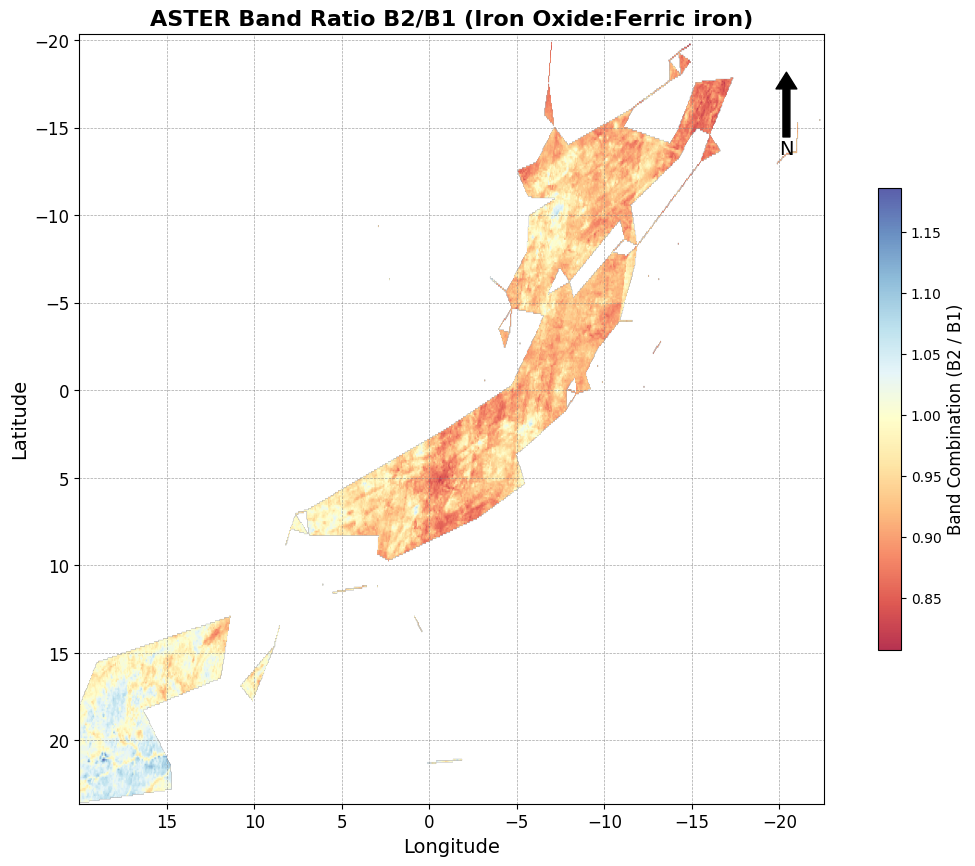

In [ ]:
import rasterio
import numpy as np
from rasterio.mask import geometry_mask
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from rasterio.plot import show

# --- 1. Load bands and mask ---
with rasterio.open(AsterImageFI) as src:
    ratio = src.read(1).astype('float32')

    extent = src.bounds

    # Mask creation using GeoJSON
    mask = geometry_mask(
        [roi_gdf.unary_union],  # Combine all geometries
        transform=src.transform,
        invert=True,
        out_shape=src.shape
    )


# --- 3. Apply Gaussian filtering ---
#smoothed_combination = gaussian_filter(ratio, sigma=10)

# --- 4. Apply the mask ---
masked_output = np.where(mask, ratio, np.nan)
print("Min value:", np.nanmin(masked_output))
print("Max value:", np.nanmax(masked_output))


# --- 5. Plotting ---
fig, ax = plt.subplots(figsize=(14, 10))
cmap = plt.cm.get_cmap('RdYlBu')

show(masked_output, ax=ax, extent=extent, cmap=cmap, alpha=0.8)

# Color bar
cbar = plt.colorbar(ax.images[0], ax=ax, orientation='vertical', shrink=0.6)
cbar.set_label('Band Combination (B2 / B1)', fontsize=12)

# Styling
plt.title('ASTER Band Ratio B2/B1 (Iron Oxide:Ferric iron)', fontsize=16, fontweight='bold')
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

# North Arrow
x, y, arrow_length = 0.95, 0.95, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=14, xycoords=ax.transAxes)

# Save figure
output_file = 'ASTER_Band_CombinationFI.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

## Ferrous iron, Fe2+


In [ ]:
datasetF2= ee.ImageCollection('ASTER/AST_L1T_003') \
            .filter(ee.Filter.date('2000-01-01', '2007-12-31')) \
            .filterBounds(roi_geometry) \
            .filter(ee.Filter.lt('CLOUDCOVER', 5));

mineralIndexF2 = datasetF2.map(lambda img: img.expression(
    '(B05 / B3N) + (B01 / B02)',
    {
      'B05': img.select('B05'),
      'B3N': img.select('B3N'),
      'B02': img.select('B02'),
      'B01': img.select('B01')
    }
))

# Clip the dataset to the ROI
clipped_MineralIndexF2 = mineralIndexF2.map(lambda img: img.clip(roi_geometry))
meanMineralIndexF2 = clipped_MineralIndexF2.median()

# Define visualization parameters for the mineral index.
mineralIndexVis = {
    'min': 0.0,
    'max': 2.0,
    'palette': ['blue', 'white', 'red']
}

# Display the index on an interactive map
Map = geemap.Map()
Map.addLayer(meanMineralIndexF2, mineralIndexVis, 'Mineral Index (B05/B3N)')
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
!pip install --q matplotlib
!pip install --q rasterio
!pip install --q geopandas

# Import libraries and authenticate

import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import rasterio
from rasterio.plot import show
import numpy as np
from rasterio.features import geometry_mask  # Correct import


# 3. Convert the ee.Geometry to an ee.Feature
roi_feature_final = ee.Feature(roi_geometry)

# 4. Wrap that feature in a FeatureCollection
roi_fc_final = ee.FeatureCollection([roi_feature_final])

# Export the ROI as a GeoJSON
roi_geojson = 'roi.geojson'
geemap.ee_export_vector(roi_fc_final, filename=roi_geojson)

# Load the GeoJSON into a GeoDataFrame
roi_gdf = gpd.read_file(roi_geojson)

Generating URL ...
Please wait ...
Data downloaded to /content/roi.geojson


In [ ]:
# Define the file path to save the downloaded raster image
AsterImageF2 = 'AsterMineralIndexF2.tif'

# Export the mean mineral index image as a GeoTIFF.
# Use the entire ROI geometry and a scale of 30 meters.
geemap.ee_export_image(
    meanMineralIndexF2,
    filename=AsterImageF2,
    scale=500,
    region=roi.geometry().getInfo(),  # Use full ROI geometry (not just the bounds)
    file_per_band=False
)

Generating URL ...
Please wait ...
Data downloaded to /content/AsterMineralIndexF2.tif


Min value: 1.7792083
Max value: 2.4198344


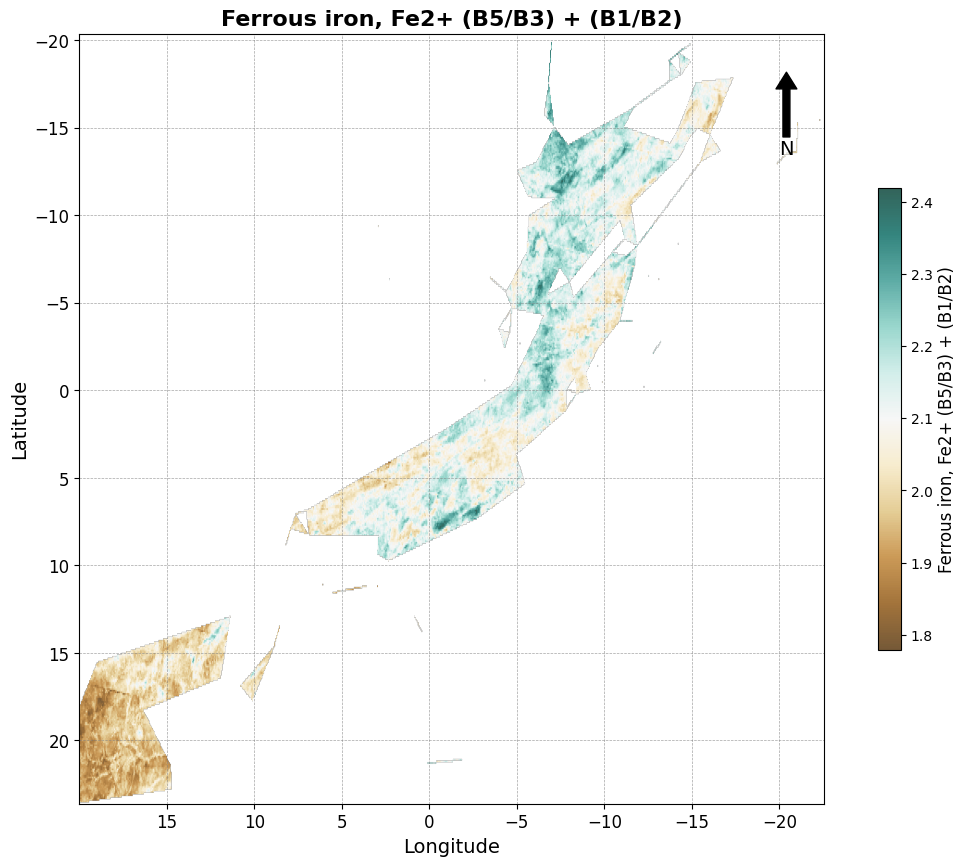

In [ ]:
import rasterio
import numpy as np
from rasterio.mask import geometry_mask
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from rasterio.plot import show

# --- 1. Load bands and mask ---
with rasterio.open(AsterImageF2) as src:
    ratio = src.read(1).astype('float32')

    extent = src.bounds

    # Mask creation using GeoJSON
    mask = geometry_mask(
        [roi_gdf.unary_union],  # Combine all geometries
        transform=src.transform,
        invert=True,
        out_shape=src.shape
    )


# --- 3. Apply Gaussian filtering ---
#smoothed_combination = gaussian_filter(ratio, sigma=10)

# --- 4. Apply the mask ---
masked_output = np.where(mask, ratio, np.nan)
print("Min value:", np.nanmin(masked_output))
print("Max value:", np.nanmax(masked_output))


# --- 5. Plotting ---
fig, ax = plt.subplots(figsize=(14, 10))
cmap = plt.cm.get_cmap('BrBG')

show(masked_output, ax=ax, extent=extent, cmap=cmap, alpha=0.8)

# Color bar
cbar = plt.colorbar(ax.images[0], ax=ax, orientation='vertical', shrink=0.6)
cbar.set_label('Ferrous iron, Fe2+ (B5/B3) + (B1/B2)', fontsize=12)

# Styling
plt.title('Ferrous iron, Fe2+ (B5/B3) + (B1/B2)', fontsize=16, fontweight='bold')
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

# North Arrow
x, y, arrow_length = 0.95, 0.95, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=14, xycoords=ax.transAxes)

# Save figure
output_file = 'ASTER_Band_CombinationF2.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

## Laterite

In [ ]:
datasetL= ee.ImageCollection('ASTER/AST_L1T_003') \
            .filter(ee.Filter.date('2000-01-01', '2007-12-31')) \
            .filterBounds(roi_geometry) \
            .filter(ee.Filter.lt('CLOUDCOVER', 5));

mineralIndexL = datasetL.map(lambda img: img.expression(
    '(B04 / B05)',
    {
      'B04': img.select('B04'),
      'B05': img.select('B05')
    }
))

# Clip the dataset to the ROI
clipped_MineralIndexL = mineralIndexL.map(lambda img: img.clip(roi_geometry))
meanMineralIndexL = clipped_MineralIndexL.median()

# Define visualization parameters for the mineral index.
mineralIndexVis = {
    'min': 0.0,
    'max': 2.0,
    'palette': ['blue', 'white', 'red']
}

# Display the index on an interactive map
Map = geemap.Map()
Map.addLayer(meanMineralIndexL, mineralIndexVis, 'Mineral Index (B05/B3N)')
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
!pip install --q matplotlib
!pip install --q rasterio
!pip install --q geopandas

# Import libraries and authenticate

import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import rasterio
from rasterio.plot import show
import numpy as np
from rasterio.features import geometry_mask  # Correct import


# 3. Convert the ee.Geometry to an ee.Feature
roi_feature_final = ee.Feature(roi_geometry)

# 4. Wrap that feature in a FeatureCollection
roi_fc_final = ee.FeatureCollection([roi_feature_final])

# Export the ROI as a GeoJSON
roi_geojson = 'roi.geojson'
geemap.ee_export_vector(roi_fc_final, filename=roi_geojson)

# Load the GeoJSON into a GeoDataFrame
roi_gdf = gpd.read_file(roi_geojson)

Generating URL ...
Please wait ...
Data downloaded to /content/roi.geojson


In [ ]:
# Define the file path to save the downloaded raster image
AsterImageL = 'AsterMineralIndexL.tif'

# Export the mean mineral index image as a GeoTIFF.
# Use the entire ROI geometry and a scale of 30 meters.
geemap.ee_export_image(
    meanMineralIndexL,
    filename=AsterImageL,
    scale=500,
    region=roi.geometry().getInfo(),  # Use full ROI geometry (not just the bounds)
    file_per_band=False
)

Generating URL ...
Please wait ...
Data downloaded to /content/AsterMineralIndexL.tif


Min value: 0.9741379
Max value: 1.2753624


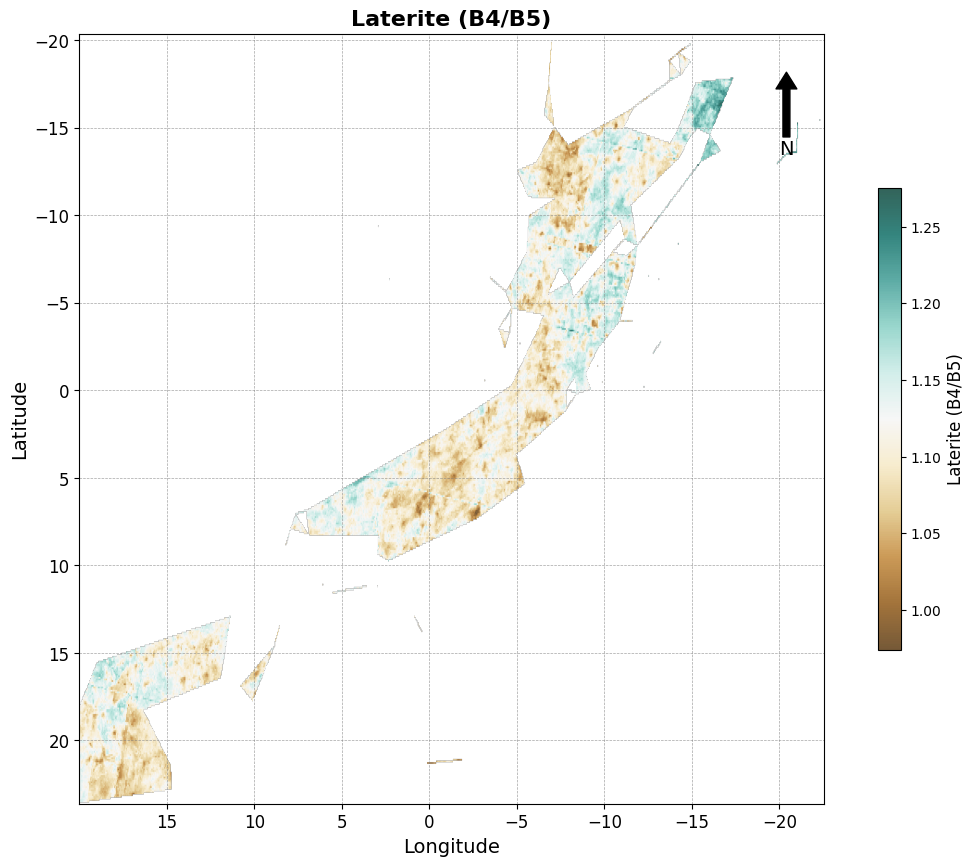

In [ ]:
import rasterio
import numpy as np
from rasterio.mask import geometry_mask
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from rasterio.plot import show

# --- 1. Load bands and mask ---
with rasterio.open(AsterImageL) as src:
    ratio = src.read(1).astype('float32')

    extent = src.bounds

    # Mask creation using GeoJSON
    mask = geometry_mask(
        [roi_gdf.unary_union],  # Combine all geometries
        transform=src.transform,
        invert=True,
        out_shape=src.shape
    )


# --- 3. Apply Gaussian filtering ---
#smoothed_combination = gaussian_filter(ratio, sigma=10)

# --- 4. Apply the mask ---
masked_output = np.where(mask, ratio, np.nan)
print("Min value:", np.nanmin(masked_output))
print("Max value:", np.nanmax(masked_output))


# --- 5. Plotting ---
fig, ax = plt.subplots(figsize=(14, 10))
cmap = plt.cm.get_cmap('BrBG')

show(masked_output, ax=ax, extent=extent, cmap=cmap, alpha=0.8)

# Color bar
cbar = plt.colorbar(ax.images[0], ax=ax, orientation='vertical', shrink=0.6)
cbar.set_label('Laterite (B4/B5)', fontsize=12)

# Styling
plt.title('Laterite (B4/B5)', fontsize=16, fontweight='bold')
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

# North Arrow
x, y, arrow_length = 0.95, 0.95, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=14, xycoords=ax.transAxes)

# Save figure
output_file = 'ASTER_Band_CombinationL.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

# Carbonates/Mafic Minerals

## Carbonate / Chlorite / Epidote

In [ ]:
datasetCCE= ee.ImageCollection('ASTER/AST_L1T_003') \
            .filter(ee.Filter.date('2000-01-01', '2007-12-31')) \
            .filterBounds(roi_geometry) \
            .filter(ee.Filter.lt('CLOUDCOVER', 5));

mineralIndexCCE = datasetCCE.map(lambda img: img.expression(
    '((B07 + B09) / B08)',
    {
      'B07': img.select('B07'),
      'B09': img.select('B09'),
      'B08': img.select('B08')
    }
))

# Clip the dataset to the ROI
clipped_MineralIndexCCE = mineralIndexCCE.map(lambda img: img.clip(roi_geometry))
meanMineralIndexCCE = clipped_MineralIndexCCE.median()

# Define visualization parameters for the mineral index.
mineralIndexVis = {
    'min': 0.0,
    'max': 2.0,
    'palette': ['blue', 'white', 'red']
}

# Display the index on an interactive map
Map = geemap.Map()
Map.addLayer(meanMineralIndexCCE, mineralIndexVis, 'Mineral Index (B05/B3N)')
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
!pip install --q matplotlib
!pip install --q rasterio
!pip install --q geopandas

# Import libraries and authenticate

import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import rasterio
from rasterio.plot import show
import numpy as np
from rasterio.features import geometry_mask  # Correct import


# 3. Convert the ee.Geometry to an ee.Feature
roi_feature_final = ee.Feature(roi_geometry)

# 4. Wrap that feature in a FeatureCollection
roi_fc_final = ee.FeatureCollection([roi_feature_final])

# Export the ROI as a GeoJSON
roi_geojson = 'roi.geojson'
geemap.ee_export_vector(roi_fc_final, filename=roi_geojson)

# Load the GeoJSON into a GeoDataFrame
roi_gdf = gpd.read_file(roi_geojson)

Generating URL ...
Please wait ...
Data downloaded to /content/roi.geojson


In [ ]:
# Define the file path to save the downloaded raster image
AsterImageCCE = 'AsterMineralIndexCCE.tif'

# Export the mean mineral index image as a GeoTIFF.
# Use the entire ROI geometry and a scale of 30 meters.
geemap.ee_export_image(
    meanMineralIndexCCE,
    filename=AsterImageCCE,
    scale=500,
    region=roi.geometry().getInfo(),  # Use full ROI geometry (not just the bounds)
    file_per_band=False
)

Generating URL ...
Please wait ...
Data downloaded to /content/AsterMineralIndexCCE.tif


Min value: 1.7974683
Max value: 2.0132504


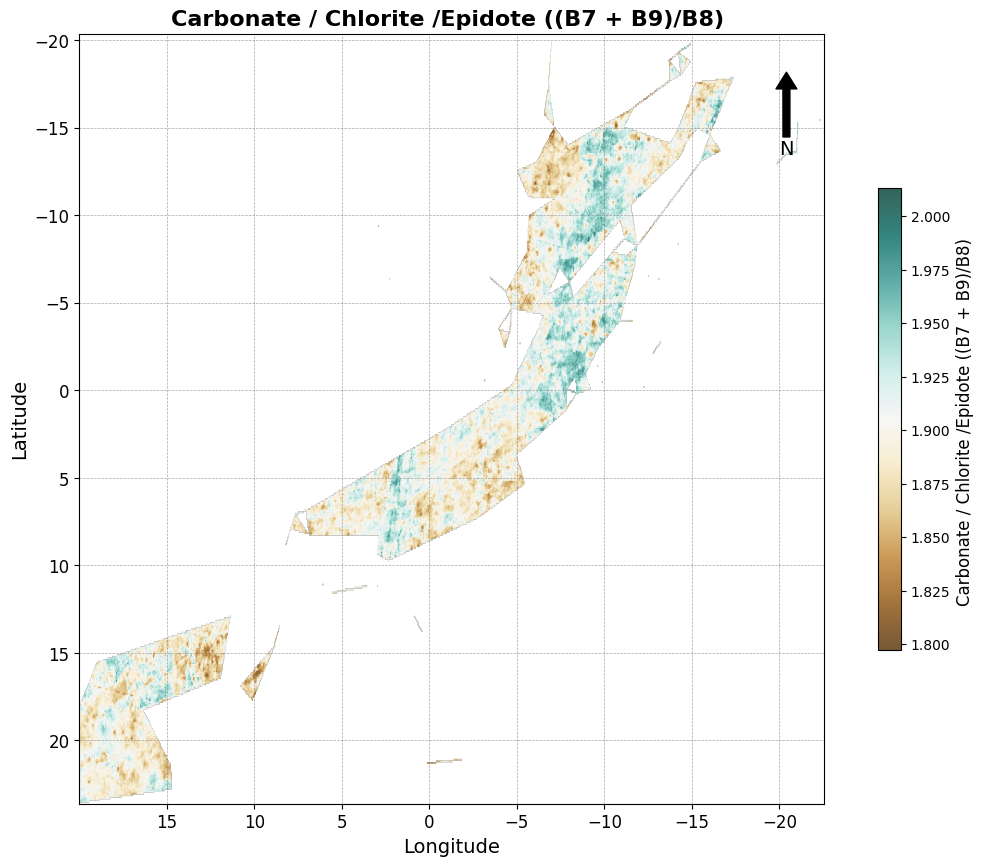

In [ ]:
import rasterio
import numpy as np
from rasterio.mask import geometry_mask
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from rasterio.plot import show

# --- 1. Load bands and mask ---
with rasterio.open(AsterImageCCE) as src:
    ratio = src.read(1).astype('float32')

    extent = src.bounds

    # Mask creation using GeoJSON
    mask = geometry_mask(
        [roi_gdf.unary_union],  # Combine all geometries
        transform=src.transform,
        invert=True,
        out_shape=src.shape
    )


# --- 3. Apply Gaussian filtering ---
#smoothed_combination = gaussian_filter(ratio, sigma=10)

# --- 4. Apply the mask ---
masked_output = np.where(mask, ratio, np.nan)
print("Min value:", np.nanmin(masked_output))
print("Max value:", np.nanmax(masked_output))


# --- 5. Plotting ---
fig, ax = plt.subplots(figsize=(14, 10))
cmap = plt.cm.get_cmap('BrBG')

show(masked_output, ax=ax, extent=extent, cmap=cmap, alpha=0.8)

# Color bar
cbar = plt.colorbar(ax.images[0], ax=ax, orientation='vertical', shrink=0.6)
cbar.set_label('Carbonate / Chlorite /Epidote ((B7 + B9)/B8) ', fontsize=12)

# Styling
plt.title('Carbonate / Chlorite /Epidote ((B7 + B9)/B8) ', fontsize=16, fontweight='bold')
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

# North Arrow
x, y, arrow_length = 0.95, 0.95, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=14, xycoords=ax.transAxes)

# Save figure
output_file = 'ASTER_Band_CombinationCCE.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

# Silicates

## Sericite / Muscovite /Illite / Smectite


In [ ]:
datasetSMIS= ee.ImageCollection('ASTER/AST_L1T_003') \
            .filter(ee.Filter.date('2000-01-01', '2007-12-31')) \
            .filterBounds(roi_geometry) \
            .filter(ee.Filter.lt('CLOUDCOVER', 5));

mineralIndexSMIS = datasetSMIS.map(lambda img: img.expression(
    '((B05 + B07) / B06)',
    {
      'B05': img.select('B05'),
      'B07': img.select('B07'),
      'B06': img.select('B06')
    }
))

# Clip the dataset to the ROI
clipped_MineralIndexSMIS = mineralIndexSMIS.map(lambda img: img.clip(roi_geometry))
meanMineralIndexSMIS = clipped_MineralIndexSMIS.median()

# Define visualization parameters for the mineral index.
mineralIndexVis = {
    'min': 0.0,
    'max': 2.0,
    'palette': ['blue', 'white', 'red']
}

# Display the index on an interactive map
Map = geemap.Map()
Map.addLayer(meanMineralIndexSMIS, mineralIndexVis, 'Mineral Index (B05/B3N)')
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
!pip install --q matplotlib
!pip install --q rasterio
!pip install --q geopandas

# Import libraries and authenticate

import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import rasterio
from rasterio.plot import show
import numpy as np
from rasterio.features import geometry_mask  # Correct import


# 3. Convert the ee.Geometry to an ee.Feature
roi_feature_final = ee.Feature(roi_geometry)

# 4. Wrap that feature in a FeatureCollection
roi_fc_final = ee.FeatureCollection([roi_feature_final])

# Export the ROI as a GeoJSON
roi_geojson = 'roi.geojson'
geemap.ee_export_vector(roi_fc_final, filename=roi_geojson)

# Load the GeoJSON into a GeoDataFrame
roi_gdf = gpd.read_file(roi_geojson)

Generating URL ...
Please wait ...
Data downloaded to /content/roi.geojson


In [ ]:
# Define the file path to save the downloaded raster image
AsterImageSMIS = 'AsterMineralIndexSMIS.tif'

# Export the mean mineral index image as a GeoTIFF.
# Use the entire ROI geometry and a scale of 30 meters.
geemap.ee_export_image(
    meanMineralIndexSMIS,
    filename=AsterImageSMIS,
    scale=500,
    region=roi.geometry().getInfo(),  # Use full ROI geometry (not just the bounds)
    file_per_band=False
)

Generating URL ...
Please wait ...
Data downloaded to /content/AsterMineralIndexSMIS.tif


Min value: 1.6825491
Max value: 1.9453158


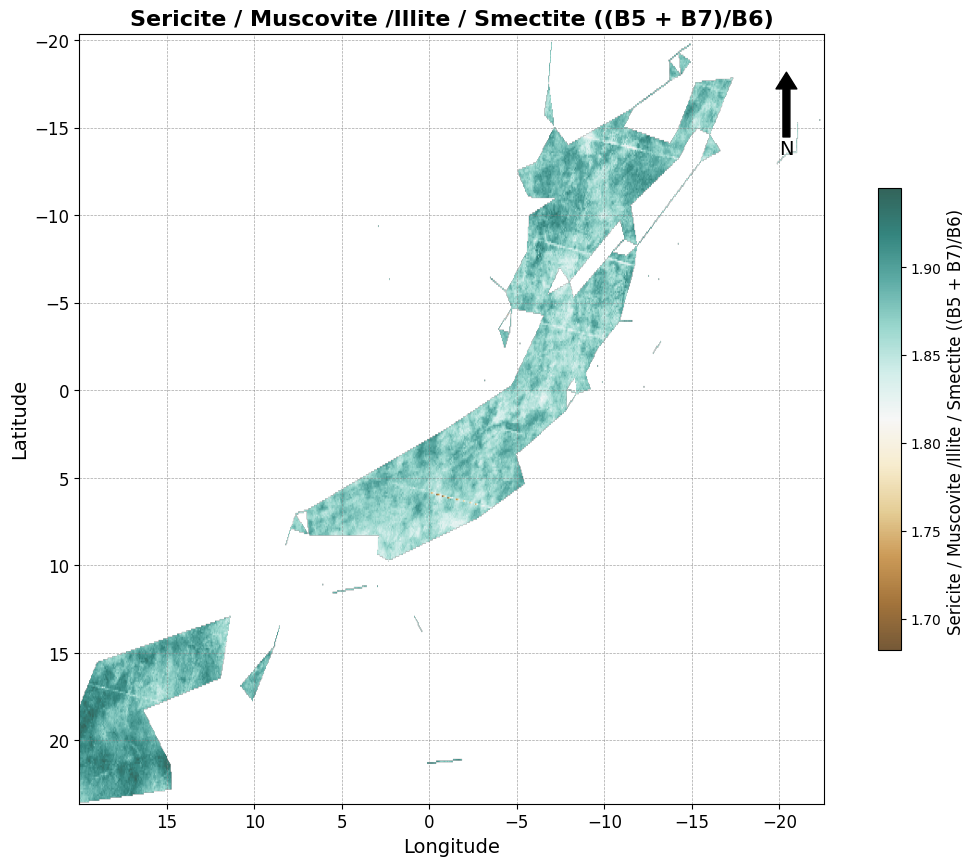

In [ ]:
import rasterio
import numpy as np
from rasterio.mask import geometry_mask
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from rasterio.plot import show

# --- 1. Load bands and mask ---
with rasterio.open(AsterImageSMIS) as src:
    ratio = src.read(1).astype('float32')

    extent = src.bounds

    # Mask creation using GeoJSON
    mask = geometry_mask(
        [roi_gdf.unary_union],  # Combine all geometries
        transform=src.transform,
        invert=True,
        out_shape=src.shape
    )


# --- 3. Apply Gaussian filtering ---
#smoothed_combination = gaussian_filter(ratio, sigma=10)

# --- 4. Apply the mask ---
masked_output = np.where(mask, ratio, np.nan)
print("Min value:", np.nanmin(masked_output))
print("Max value:", np.nanmax(masked_output))


# --- 5. Plotting ---
fig, ax = plt.subplots(figsize=(14, 10))
cmap = plt.cm.get_cmap('BrBG')

show(masked_output, ax=ax, extent=extent, cmap=cmap, alpha=0.8)

# Color bar
cbar = plt.colorbar(ax.images[0], ax=ax, orientation='vertical', shrink=0.6)
cbar.set_label('Sericite / Muscovite /Illite / Smectite ((B5 + B7)/B6) ', fontsize=12)

# Styling
plt.title('Sericite / Muscovite /Illite / Smectite ((B5 + B7)/B6)', fontsize=16, fontweight='bold')
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

# North Arrow
x, y, arrow_length = 0.95, 0.95, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=14, xycoords=ax.transAxes)

# Save figure
output_file = 'ASTER_Band_CombinationCCE.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

## Alunite / Kaolinite / *Pyrophyllite*


In [ ]:
datasetAKP= ee.ImageCollection('ASTER/AST_L1T_003') \
            .filter(ee.Filter.date('2000-01-01', '2007-12-31')) \
            .filterBounds(roi_geometry) \
            .filter(ee.Filter.lt('CLOUDCOVER', 5));

mineralIndexAKP = datasetAKP.map(lambda img: img.expression(
    '(B04 + B06)  / B05',
    {
      'B05': img.select('B05'),
      'B04': img.select('B04'),
      'B06': img.select('B06')
    }
))

# Clip the dataset to the ROI
clipped_MineralIndexAKP = mineralIndexAKP.map(lambda img: img.clip(roi_geometry))
meanMineralIndexAKP = clipped_MineralIndexAKP.median()

# Define visualization parameters for the mineral index.
mineralIndexVis = {
    'min': 0.0,
    'max': 2.0,
    'palette': ['blue', 'white', 'red']
}

# Display the index on an interactive map
Map = geemap.Map()
Map.addLayer(meanMineralIndexAKP, mineralIndexVis, 'Mineral Index (B05/B3N)')
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
!pip install --q matplotlib
!pip install --q rasterio
!pip install --q geopandas

# Import libraries and authenticate

import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import rasterio
from rasterio.plot import show
import numpy as np
from rasterio.features import geometry_mask  # Correct import


# 3. Convert the ee.Geometry to an ee.Feature
roi_feature_final = ee.Feature(roi_geometry)

# 4. Wrap that feature in a FeatureCollection
roi_fc_final = ee.FeatureCollection([roi_feature_final])

# Export the ROI as a GeoJSON
roi_geojson = 'roi.geojson'
geemap.ee_export_vector(roi_fc_final, filename=roi_geojson)

# Load the GeoJSON into a GeoDataFrame
roi_gdf = gpd.read_file(roi_geojson)

Generating URL ...
Please wait ...
Data downloaded to /content/roi.geojson


In [ ]:
# Define the file path to save the downloaded raster image
AsterImageAKP = 'AsterMineralIndexAKP.tif'

# Export the mean mineral index image as a GeoTIFF.
# Use the entire ROI geometry and a scale of 30 meters.
geemap.ee_export_image(
    meanMineralIndexAKP,
    filename=AsterImageAKP,
    scale=500,
    region=roi.geometry().getInfo(),  # Use full ROI geometry (not just the bounds)
    file_per_band=False
)

Generating URL ...
Please wait ...
Data downloaded to /content/AsterMineralIndexAKP.tif


Min value: 2.0317461
Max value: 2.3333333


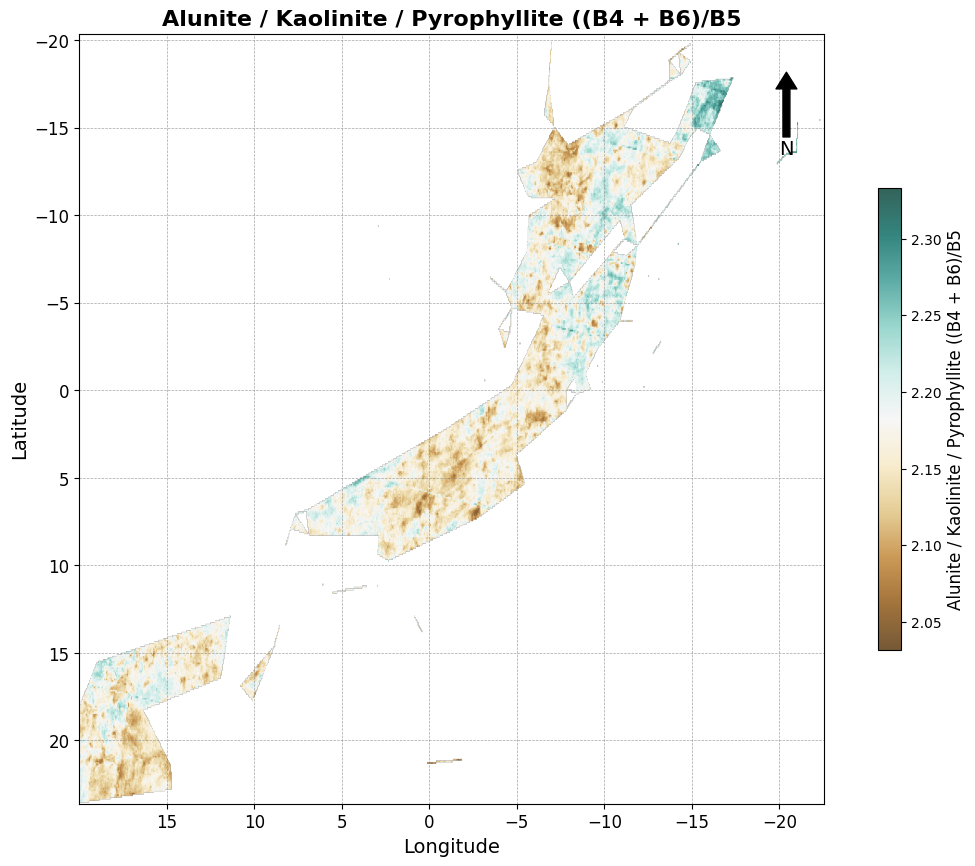

In [ ]:
import rasterio
import numpy as np
from rasterio.mask import geometry_mask
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from rasterio.plot import show

# --- 1. Load bands and mask ---
with rasterio.open(AsterImageAKP) as src:
    ratio = src.read(1).astype('float32')

    extent = src.bounds

    # Mask creation using GeoJSON
    mask = geometry_mask(
        [roi_gdf.unary_union],  # Combine all geometries
        transform=src.transform,
        invert=True,
        out_shape=src.shape
    )


# --- 3. Apply Gaussian filtering ---
#smoothed_combination = gaussian_filter(ratio, sigma=10)

# --- 4. Apply the mask ---
masked_output = np.where(mask, ratio, np.nan)
print("Min value:", np.nanmin(masked_output))
print("Max value:", np.nanmax(masked_output))


# --- 5. Plotting ---
fig, ax = plt.subplots(figsize=(14, 10))
cmap = plt.cm.get_cmap('BrBG')

show(masked_output, ax=ax, extent=extent, cmap=cmap, alpha=0.8)

# Color bar
cbar = plt.colorbar(ax.images[0], ax=ax, orientation='vertical', shrink=0.6)
cbar.set_label('Alunite / Kaolinite / Pyrophyllite ((B4 + B6)/B5', fontsize=12)

# Styling
plt.title('Alunite / Kaolinite / Pyrophyllite ((B4 + B6)/B5', fontsize=16, fontweight='bold')
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

# North Arrow
x, y, arrow_length = 0.95, 0.95, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=14, xycoords=ax.transAxes)

# Save figure
output_file = 'ASTER_Band_CombinationAKP.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

## Phengitic

In [ ]:
datasetPh= ee.ImageCollection('ASTER/AST_L1T_003') \
            .filter(ee.Filter.date('2000-01-01', '2007-12-31')) \
            .filterBounds(roi_geometry) \
            .filter(ee.Filter.lt('CLOUDCOVER', 5));

mineralIndexPh = datasetPh.map(lambda img: img.expression(
    '(B05 / B06)',
    {
      'B05': img.select('B05'),
      'B06': img.select('B06')
    }
))

# Clip the dataset to the ROI
clipped_MineralIndexPh = mineralIndexPh.map(lambda img: img.clip(roi_geometry))
meanMineralIndexPh = clipped_MineralIndexPh.median()

# Define visualization parameters for the mineral index.
mineralIndexVis = {
    'min': 0.0,
    'max': 2.0,
    'palette': ['blue', 'white', 'red']
}

# Display the index on an interactive map
Map = geemap.Map()
Map.addLayer(meanMineralIndexPh, mineralIndexVis, 'Mineral Index (B05/B3N)')
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
!pip install --q matplotlib
!pip install --q rasterio
!pip install --q geopandas

# Import libraries and authenticate

import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import rasterio
from rasterio.plot import show
import numpy as np
from rasterio.features import geometry_mask  # Correct import


# 3. Convert the ee.Geometry to an ee.Feature
roi_feature_final = ee.Feature(roi_geometry)

# 4. Wrap that feature in a FeatureCollection
roi_fc_final = ee.FeatureCollection([roi_feature_final])

# Export the ROI as a GeoJSON
roi_geojson = 'roi.geojson'
geemap.ee_export_vector(roi_fc_final, filename=roi_geojson)

# Load the GeoJSON into a GeoDataFrame
roi_gdf = gpd.read_file(roi_geojson)

Generating URL ...
Please wait ...
Data downloaded to /content/roi.geojson


In [ ]:
# Define the file path to save the downloaded raster image
AsterImagePh = 'AsterMineralIndexPh.tif'

# Export the mean mineral index image as a GeoTIFF.
# Use the entire ROI geometry and a scale of 30 meters.
geemap.ee_export_image(
    meanMineralIndexPh,
    filename=AsterImagePh,
    scale=500,
    region=roi.geometry().getInfo(),  # Use full ROI geometry (not just the bounds)
    file_per_band=False
)

Generating URL ...
Please wait ...
Data downloaded to /content/AsterMineralIndexPh.tif


Min value: 0.9275417
Max value: 0.97625


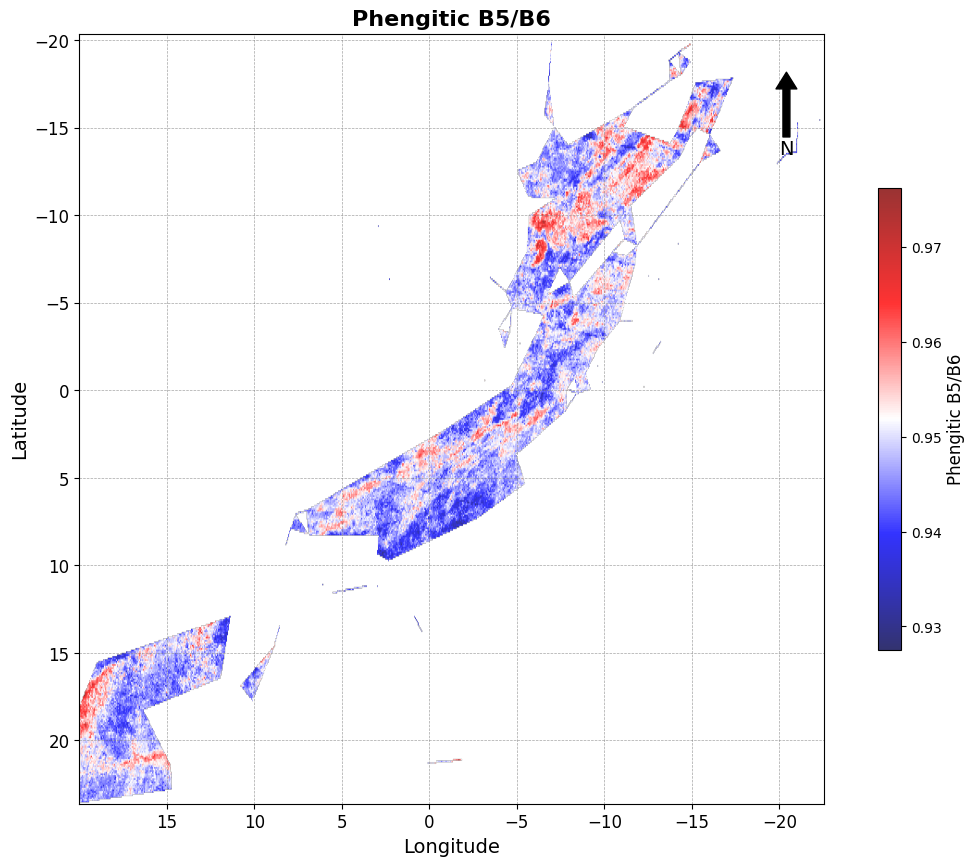

In [ ]:
import rasterio
import numpy as np
from rasterio.mask import geometry_mask
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from rasterio.plot import show

# --- 1. Load bands and mask ---
with rasterio.open(AsterImagePh) as src:
    ratio = src.read(1).astype('float32')

    extent = src.bounds

    # Mask creation using GeoJSON
    mask = geometry_mask(
        [roi_gdf.unary_union],  # Combine all geometries
        transform=src.transform,
        invert=True,
        out_shape=src.shape
    )


# --- 3. Apply Gaussian filtering ---
#smoothed_combination = gaussian_filter(ratio, sigma=10)

# --- 4. Apply the mask ---
masked_output = np.where(mask, ratio, np.nan)
print("Min value:", np.nanmin(masked_output))
print("Max value:", np.nanmax(masked_output))


# --- 5. Plotting ---
fig, ax = plt.subplots(figsize=(14, 10))
cmap = plt.cm.get_cmap('seismic')

show(masked_output, ax=ax, extent=extent, cmap=cmap, alpha=0.8)

# Color bar
cbar = plt.colorbar(ax.images[0], ax=ax, orientation='vertical', shrink=0.6)
cbar.set_label('Phengitic B5/B6', fontsize=12)

# Styling
plt.title('Phengitic B5/B6', fontsize=16, fontweight='bold')
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

# North Arrow
x, y, arrow_length = 0.95, 0.95, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=14, xycoords=ax.transAxes)

# Save figure
output_file = 'ASTER_Band_CombinationPh.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

## Alteration

In [ ]:
datasetAL= ee.ImageCollection('ASTER/AST_L1T_003') \
            .filter(ee.Filter.date('2000-01-01', '2007-12-31')) \
            .filterBounds(roi_geometry) \
            .filter(ee.Filter.lt('CLOUDCOVER', 5));

mineralIndexAL = datasetAL.map(lambda img: img.expression(
    'B04 / B05',
    {
      'B04': img.select('B04'),
      'B05': img.select('B05')
    }
))

# Clip the dataset to the ROI
clipped_MineralIndexAL = mineralIndexAL.map(lambda img: img.clip(roi_geometry))
meanMineralIndexAL = clipped_MineralIndexAL.median()

# Define visualization parameters for the mineral index.
mineralIndexVis = {
    'min': 0.0,
    'max': 2.0,
    'palette': ['blue', 'white', 'red']
}

# Display the index on an interactive map
Map = geemap.Map()
Map.addLayer(meanMineralIndexAL, mineralIndexVis, 'Mineral Index (B05/B3N)')
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
!pip install --q matplotlib
!pip install --q rasterio
!pip install --q geopandas

# Import libraries and authenticate

import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import rasterio
from rasterio.plot import show
import numpy as np
from rasterio.features import geometry_mask  # Correct import


# 3. Convert the ee.Geometry to an ee.Feature
roi_feature_final = ee.Feature(roi_geometry)

# 4. Wrap that feature in a FeatureCollection
roi_fc_final = ee.FeatureCollection([roi_feature_final])

# Export the ROI as a GeoJSON
roi_geojson = 'roi.geojson'
geemap.ee_export_vector(roi_fc_final, filename=roi_geojson)

# Load the GeoJSON into a GeoDataFrame
roi_gdf = gpd.read_file(roi_geojson)

Generating URL ...
Please wait ...
Data downloaded to /content/roi.geojson


In [ ]:
# Define the file path to save the downloaded raster image
AsterImageAL = 'AsterMineralIndexAL.tif'

# Export the mean mineral index image as a GeoTIFF.
# Use the entire ROI geometry and a scale of 30 meters.
geemap.ee_export_image(
    meanMineralIndexAL,
    filename=AsterImageAL,
    scale=500,
    region=roi.geometry().getInfo(),  # Use full ROI geometry (not just the bounds)
    file_per_band=False
)

Generating URL ...
Please wait ...
Data downloaded to /content/AsterMineralIndexAL.tif


Min value: 0.9741379
Max value: 1.2753624


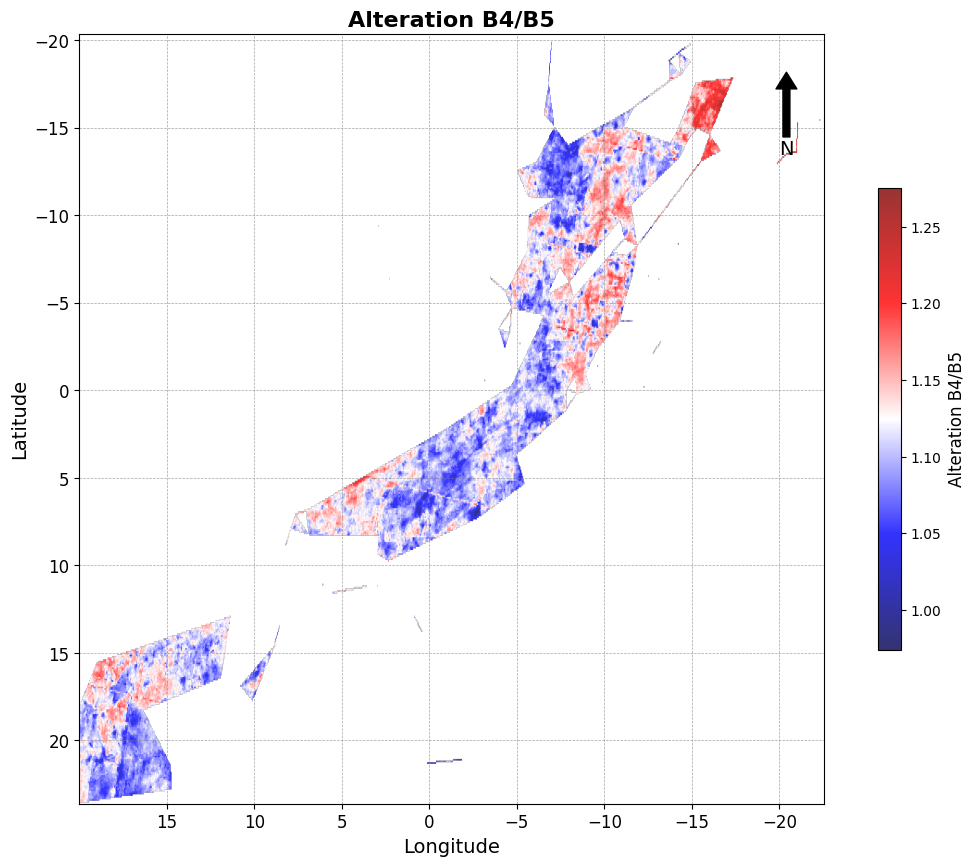

In [ ]:
import rasterio
import numpy as np
from rasterio.mask import geometry_mask
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from rasterio.plot import show

# --- 1. Load bands and mask ---
with rasterio.open(AsterImageAL) as src:
    ratio = src.read(1).astype('float32')

    extent = src.bounds

    # Mask creation using GeoJSON
    mask = geometry_mask(
        [roi_gdf.unary_union],  # Combine all geometries
        transform=src.transform,
        invert=True,
        out_shape=src.shape
    )


# --- 3. Apply Gaussian filtering ---
#smoothed_combination = gaussian_filter(ratio, sigma=10)

# --- 4. Apply the mask ---
masked_output = np.where(mask, ratio, np.nan)
print("Min value:", np.nanmin(masked_output))
print("Max value:", np.nanmax(masked_output))


# --- 5. Plotting ---
fig, ax = plt.subplots(figsize=(14, 10))
cmap = plt.cm.get_cmap('seismic')

show(masked_output, ax=ax, extent=extent, cmap=cmap, alpha=0.8)

# Color bar
cbar = plt.colorbar(ax.images[0], ax=ax, orientation='vertical', shrink=0.6)
cbar.set_label('Alteration B4/B5', fontsize=12)

# Styling
plt.title('Alteration B4/B5', fontsize=16, fontweight='bold')
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

# North Arrow
x, y, arrow_length = 0.95, 0.95, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=14, xycoords=ax.transAxes)

# Save figure
output_file = 'ASTER_Band_CombinationAL.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

## Host rock

In [ ]:
datasetHR= ee.ImageCollection('ASTER/AST_L1T_003') \
            .filter(ee.Filter.date('2000-01-01', '2007-12-31')) \
            .filterBounds(roi_geometry) \
            .filter(ee.Filter.lt('CLOUDCOVER', 5));

mineralIndexHR = datasetHR.map(lambda img: img.expression(
    'B05 / B06',
    {
      'B05': img.select('B05'),
      'B06': img.select('B06')
    }
))

# Clip the dataset to the ROI
clipped_MineralIndexHR = mineralIndexHR.map(lambda img: img.clip(roi_geometry))
meanMineralIndexHR = clipped_MineralIndexHR.median()

# Define visualization parameters for the mineral index.
mineralIndexVis = {
    'min': 0.0,
    'max': 2.0,
    'palette': ['blue', 'white', 'red']
}

# Display the index on an interactive map
Map = geemap.Map()
Map.addLayer(meanMineralIndexHR, mineralIndexVis, 'Mineral Index (B05/B3N)')
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
!pip install --q matplotlib
!pip install --q rasterio
!pip install --q geopandas

# Import libraries and authenticate

import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import rasterio
from rasterio.plot import show
import numpy as np
from rasterio.features import geometry_mask  # Correct import


# 3. Convert the ee.Geometry to an ee.Feature
roi_feature_final = ee.Feature(roi_geometry)

# 4. Wrap that feature in a FeatureCollection
roi_fc_final = ee.FeatureCollection([roi_feature_final])

# Export the ROI as a GeoJSON
roi_geojson = 'roi.geojson'
geemap.ee_export_vector(roi_fc_final, filename=roi_geojson)

# Load the GeoJSON into a GeoDataFrame
roi_gdf = gpd.read_file(roi_geojson)

Generating URL ...
Please wait ...
Data downloaded to /content/roi.geojson


In [ ]:
# Define the file path to save the downloaded raster image
AsterImageHR = 'AsterMineralIndexHR.tif'

# Export the mean mineral index image as a GeoTIFF.
# Use the entire ROI geometry and a scale of 30 meters.
geemap.ee_export_image(
    meanMineralIndexHR,
    filename=AsterImageHR,
    scale=500,
    region=roi.geometry().getInfo(),  # Use full ROI geometry (not just the bounds)
    file_per_band=False
)

Generating URL ...
Please wait ...
Data downloaded to /content/AsterMineralIndexHR.tif


Min value: 0.9275417
Max value: 0.97625


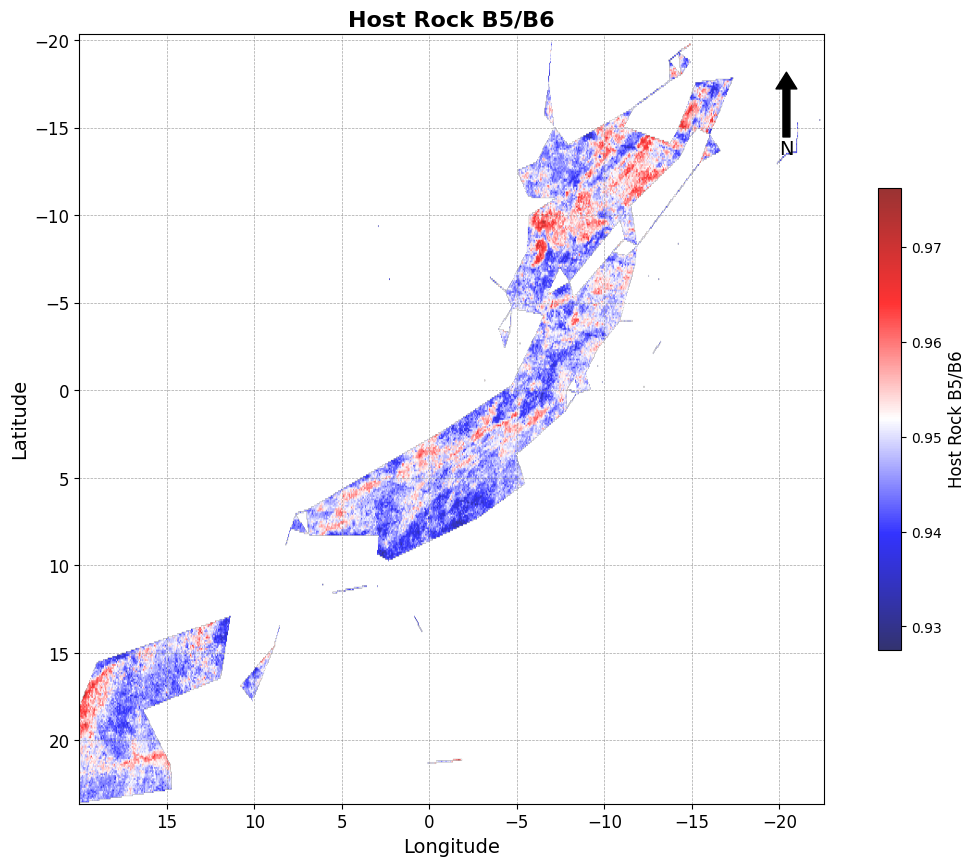

In [ ]:
import rasterio
import numpy as np
from rasterio.mask import geometry_mask
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from rasterio.plot import show

# --- 1. Load bands and mask ---
with rasterio.open(AsterImageHR) as src:
    ratio = src.read(1).astype('float32')

    extent = src.bounds

    # Mask creation using GeoJSON
    mask = geometry_mask(
        [roi_gdf.unary_union],  # Combine all geometries
        transform=src.transform,
        invert=True,
        out_shape=src.shape
    )


# --- 3. Apply Gaussian filtering ---
#smoothed_combination = gaussian_filter(ratio, sigma=10)

# --- 4. Apply the mask ---
masked_output = np.where(mask, ratio, np.nan)
print("Min value:", np.nanmin(masked_output))
print("Max value:", np.nanmax(masked_output))


# --- 5. Plotting ---
fig, ax = plt.subplots(figsize=(14, 10))
cmap = plt.cm.get_cmap('seismic')

show(masked_output, ax=ax, extent=extent, cmap=cmap, alpha=0.8)

# Color bar
cbar = plt.colorbar(ax.images[0], ax=ax, orientation='vertical', shrink=0.6)
cbar.set_label('Host Rock B5/B6', fontsize=12)

# Styling
plt.title('Host Rock B5/B6', fontsize=16, fontweight='bold')
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

# North Arrow
x, y, arrow_length = 0.95, 0.95, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=14, xycoords=ax.transAxes)

# Save figure
output_file = 'ASTER_Band_CombinationHR.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

# Silica

## Quartz Rich Rocks

In [ ]:
datasetQ= ee.ImageCollection('ASTER/AST_L1T_003') \
            .filter(ee.Filter.date('2000-01-01', '2007-12-31')) \
            .filterBounds(roi_geometry) \
            .filter(ee.Filter.lt('CLOUDCOVER', 5));

mineralIndexQ = datasetQ.map(lambda img: img.expression(
    'B14 / B12',
    {
      'B14': img.select('B14'),
      'B12': img.select('B12')
    }
))

# Clip the dataset to the ROI
clipped_MineralIndexQ = mineralIndexQ.map(lambda img: img.clip(roi_geometry))
meanMineralIndexQ = clipped_MineralIndexQ.median()

# Define visualization parameters for the mineral index.
mineralIndexVis = {
    'min': 0.0,
    'max': 2.0,
    'palette': ['blue', 'white', 'red']
}

# Display the index on an interactive map
Map = geemap.Map()
Map.addLayer(meanMineralIndexQ, mineralIndexVis, 'Mineral Index (B05/B3N)')
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
!pip install --q matplotlib
!pip install --q rasterio
!pip install --q geopandas

# Import libraries and authenticate

import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import rasterio
from rasterio.plot import show
import numpy as np
from rasterio.features import geometry_mask  # Correct import


# 3. Convert the ee.Geometry to an ee.Feature
roi_feature_final = ee.Feature(roi_geometry)

# 4. Wrap that feature in a FeatureCollection
roi_fc_final = ee.FeatureCollection([roi_feature_final])

# Export the ROI as a GeoJSON
roi_geojson = 'roi.geojson'
geemap.ee_export_vector(roi_fc_final, filename=roi_geojson)

# Load the GeoJSON into a GeoDataFrame
roi_gdf = gpd.read_file(roi_geojson)

Generating URL ...
Please wait ...
Data downloaded to /content/roi.geojson


In [ ]:
# Define the file path to save the downloaded raster image
AsterImageQ = 'AsterMineralIndexQ.tif'

# Export the mean mineral index image as a GeoTIFF.
# Use the entire ROI geometry and a scale of 30 meters.
geemap.ee_export_image(
    meanMineralIndexQ,
    filename=AsterImageQ,
    scale=500,
    region=roi.geometry().getInfo(),  # Use full ROI geometry (not just the bounds)
    file_per_band=False
)

Generating URL ...
Please wait ...
Data downloaded to /content/AsterMineralIndexQ.tif


Min value: 1.1775059
Max value: 1.4231379


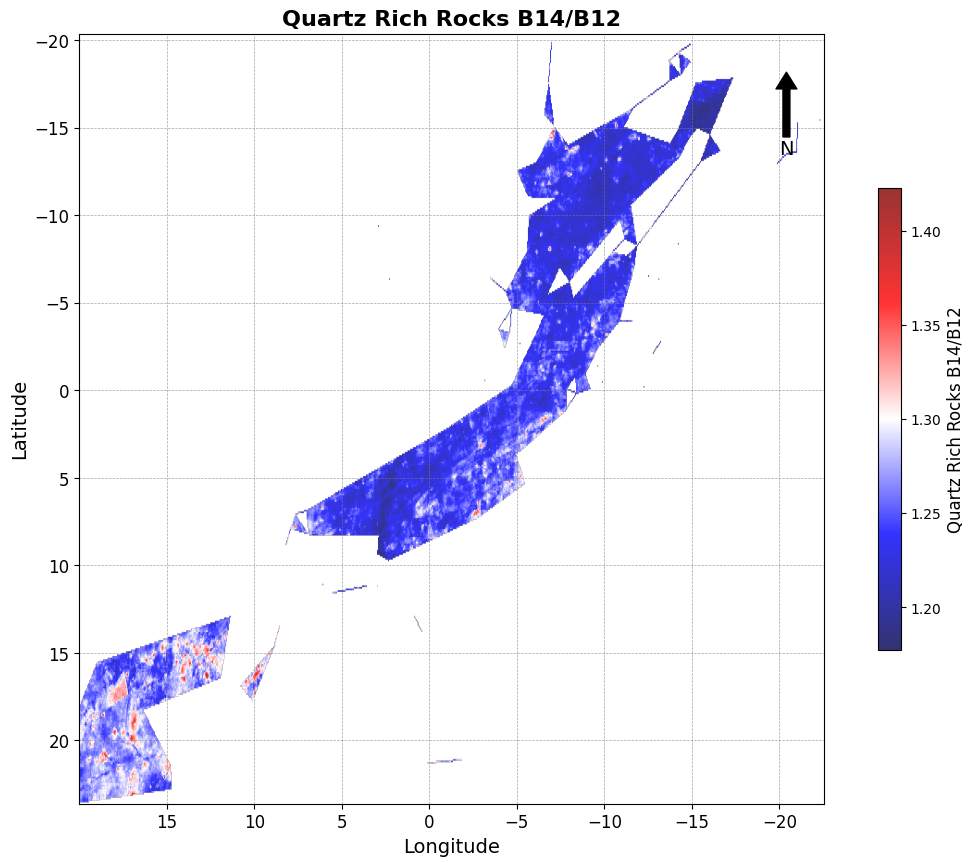

In [ ]:
import rasterio
import numpy as np
from rasterio.mask import geometry_mask
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from rasterio.plot import show

# --- 1. Load bands and mask ---
with rasterio.open(AsterImageQ) as src:
    ratio = src.read(1).astype('float32')

    extent = src.bounds

    # Mask creation using GeoJSON
    mask = geometry_mask(
        [roi_gdf.unary_union],  # Combine all geometries
        transform=src.transform,
        invert=True,
        out_shape=src.shape
    )


# --- 3. Apply Gaussian filtering ---
#smoothed_combination = gaussian_filter(ratio, sigma=10)

# --- 4. Apply the mask ---
masked_output = np.where(mask, ratio, np.nan)
print("Min value:", np.nanmin(masked_output))
print("Max value:", np.nanmax(masked_output))


# --- 5. Plotting ---
fig, ax = plt.subplots(figsize=(14, 10))
cmap = plt.cm.get_cmap('seismic')

show(masked_output, ax=ax, extent=extent, cmap=cmap, alpha=0.8)

# Color bar
cbar = plt.colorbar(ax.images[0], ax=ax, orientation='vertical', shrink=0.6)
cbar.set_label('Quartz Rich Rocks B14/B12', fontsize=12)

# Styling
plt.title('Quartz Rich Rocks B14/B12', fontsize=16, fontweight='bold')
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

# North Arrow
x, y, arrow_length = 0.95, 0.95, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=14, xycoords=ax.transAxes)

# Save figure
output_file = 'ASTER_Band_CombinationQ.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

## Silica

In [ ]:
datasetSI= ee.ImageCollection('ASTER/AST_L1T_003') \
            .filter(ee.Filter.date('2000-01-01', '2007-12-31')) \
            .filterBounds(roi_geometry) \
            .filter(ee.Filter.lt('CLOUDCOVER', 5));

mineralIndexSI = datasetSI.map(lambda img: img.expression(
    'B13 / B10',
    {
      'B11': img.select('B11'),
      'B10': img.select('B10'),
      'B13': img.select('B13')
    }
))

# Clip the dataset to the ROI
clipped_MineralIndexSI = mineralIndexSI.map(lambda img: img.clip(roi_geometry))
meanMineralIndexSI = clipped_MineralIndexSI.median()

# Define visualization parameters for the mineral index.
mineralIndexVis = {
    'min': 0.0,
    'max': 2.0,
    'palette': ['blue', 'white', 'red']
}

# Display the index on an interactive map
Map = geemap.Map()
Map.addLayer(meanMineralIndexSI, mineralIndexVis, 'Mineral Index (B05/B3N)')
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
!pip install --q matplotlib
!pip install --q rasterio
!pip install --q geopandas

# Import libraries and authenticate

import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import rasterio
from rasterio.plot import show
import numpy as np
from rasterio.features import geometry_mask  # Correct import


# 3. Convert the ee.Geometry to an ee.Feature
roi_feature_final = ee.Feature(roi_geometry)

# 4. Wrap that feature in a FeatureCollection
roi_fc_final = ee.FeatureCollection([roi_feature_final])

# Export the ROI as a GeoJSON
roi_geojson = 'roi.geojson'
geemap.ee_export_vector(roi_fc_final, filename=roi_geojson)

# Load the GeoJSON into a GeoDataFrame
roi_gdf = gpd.read_file(roi_geojson)

Generating URL ...
Please wait ...
Data downloaded to /content/roi.geojson


In [ ]:
# Define the file path to save the downloaded raster image
AsterImageSI = 'AsterMineralIndexSI.tif'

# Export the mean mineral index image as a GeoTIFF.
# Use the entire ROI geometry and a scale of 30 meters.
geemap.ee_export_image(
    meanMineralIndexSI,
    filename=AsterImageSI,
    scale=500,
    region=roi.geometry().getInfo(),  # Use full ROI geometry (not just the bounds)
    file_per_band=False
)

Generating URL ...
Please wait ...
Data downloaded to /content/AsterMineralIndexSI.tif


Min value: 1.3215523
Max value: 1.5177896


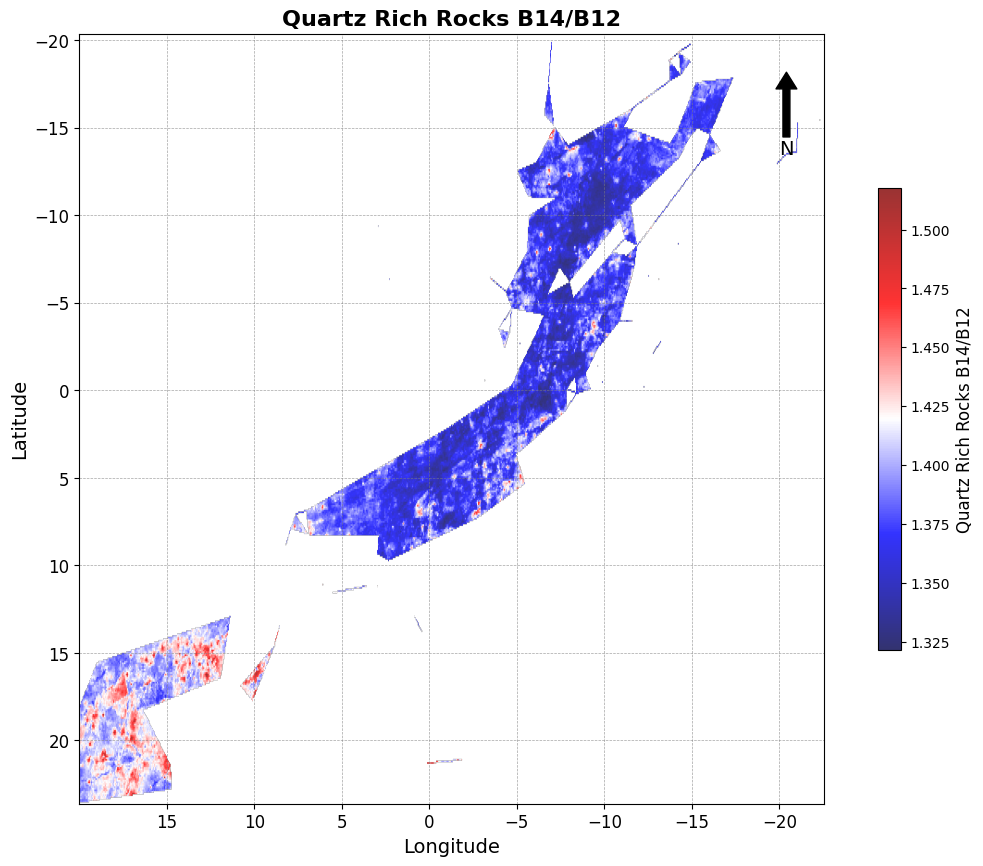

In [ ]:
import rasterio
import numpy as np
from rasterio.mask import geometry_mask
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from rasterio.plot import show

# --- 1. Load bands and mask ---
with rasterio.open(AsterImageSI) as src:
    ratio = src.read(1).astype('float32')

    extent = src.bounds

    # Mask creation using GeoJSON
    mask = geometry_mask(
        [roi_gdf.unary_union],  # Combine all geometries
        transform=src.transform,
        invert=True,
        out_shape=src.shape
    )


# --- 3. Apply Gaussian filtering ---
#smoothed_combination = gaussian_filter(ratio, sigma=10)

# --- 4. Apply the mask ---
masked_output = np.where(mask, ratio, np.nan)
print("Min value:", np.nanmin(masked_output))
print("Max value:", np.nanmax(masked_output))


# --- 5. Plotting ---
fig, ax = plt.subplots(figsize=(14, 10))
cmap = plt.cm.get_cmap('seismic')

show(masked_output, ax=ax, extent=extent, cmap=cmap, alpha=0.8)

# Color bar
cbar = plt.colorbar(ax.images[0], ax=ax, orientation='vertical', shrink=0.6)
cbar.set_label('Quartz Rich Rocks B14/B12', fontsize=12)

# Styling
plt.title('Quartz Rich Rocks B14/B12', fontsize=16, fontweight='bold')
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)

# North Arrow
x, y, arrow_length = 0.95, 0.95, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=14, xycoords=ax.transAxes)

# Save figure
output_file = 'ASTER_Band_CombinationQ.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()